Прямая задача

ПРЯМАЯ ЗАДАЧА v5: АНАЛИЗ ОРБИТАЛЬНОГО ДОПЛЕРА
Загружено SPICE kernels:  3

[1] Загрузка данных...
  Начальное состояние:
    |r| = 12449.0 км
    |v| = 2.3388 км/с
  Doppler: 1578 точек, 4 сессий

[2] Интегрирование орбиты...
  Радиус:  3514.0 - 57199.7 км

[3] Вычисление доплера...
  Вычислено: 1578 точек

АНАЛИЗ КОМПОНЕНТ ДОПЛЕРА

  Полный доплер (Марс-Земля + орбита КА):
    Модель:      -483437 to -434376 Гц
    Наблюдаемый: -7498 to 17884 Гц

  Орбитальный доплер (только КА вокруг Марса):
    Модель:     -26560 to 563 Гц
    Наблюдаемый: -7498 to 17884 Гц

  Range-rates:
    Полный uplink:       8.1453 ± 0.2213 км/с
    Марс contribution:   8.3964 ± 0.1692 км/с
    Орбита КА:           -0.2511 ± 0.1427 км/с
    Скорость КА-Марс:   0.6783 ± 0.4796 км/с

СРАВНЕНИЕ ОРБИТАЛЬНОГО ДОПЛЕРА С НАБЛЮДЕНИЯМИ

  Сессия 0 (DSS-65):
    Корреляция obs vs model (detrended): 0.9432
    Масштаб (std_obs / std_model):       0.3547
    СКО наблюдений (detrended):          525.9 Гц
    СКО модели (de

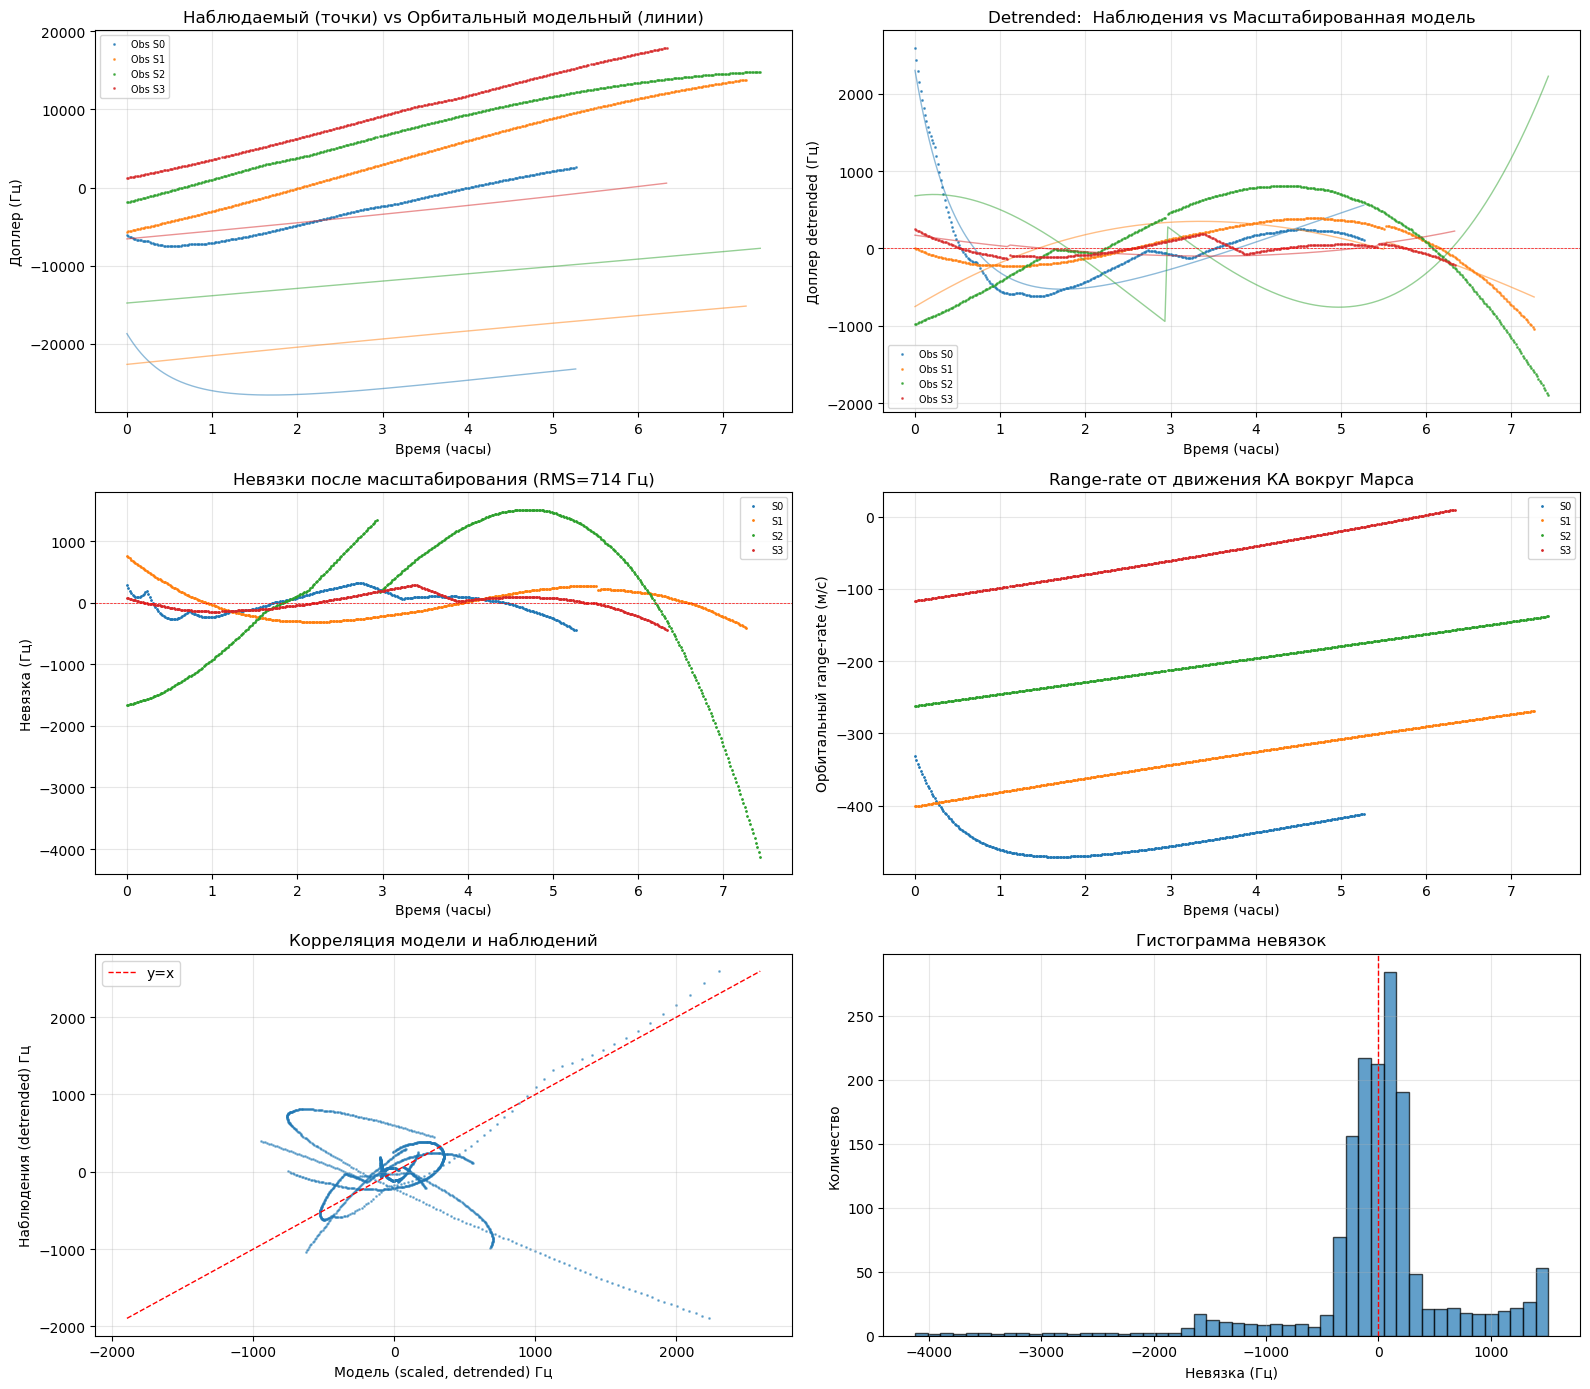


Готово!


In [31]:
"""
Прямая задача: работа с вариациями доплера. 

Ключевая идея: 
- DSN ramping компенсирует предсказанный доплер от движения Марс-Земля
- Остаётся:   орбитальный доплер КА вокруг Марса + ошибки орбиты
- Моделируем только ВАРИАЦИИ доплера, вычитая тренд
"""

import numpy as np
import pandas as pd
import spiceypy as spice
from scipy.interpolate import interp1d
from scipy.signal import detrend
import os
import matplotlib.pyplot as plt
from datetime import datetime

# =============================================================================
# КОНСТАНТЫ
# =============================================================================

KERNEL_DIR = './spice_data/'
GEOMETRY_FILE = './output_data/mgs_geometry.csv'
DOPPLER_FILE = './output_data/mgs_doppler_CLEANED.csv'
OUTPUT_DIR = './output_data/'

GM = {
    'sun':       132712440041.93938,
    'mercury':   22031.868551,
    'venus':    324858.592,
    'earth':    398600.435507,
    'moon':     4902.800118,
    'mars':     42828.375816,
    'jupiter':   126712764.100,
    'saturn':   37940584.841,
    'uranus':   5794556.400,
    'neptune':  6836527.100,
}

C_LIGHT = 299792.458
MARS_RE = 3396.19
F_DOWNLINK = 8.4e9  # Hz, X-band downlink
M_TRANSPONDER = 880.0 / 749.0

DSN_STATIONS = {
    14: {'lon': -116.889, 'lat':   35.426, 'height': 1001.39},
    15: {'lon': -116.887, 'lat':   35.422, 'height':   973.21},
    43: {'lon': 148.983, 'lat':  -35.403, 'height':   688.87},
    45: {'lon': 148.978, 'lat':  -35.402, 'height':   674.35},
    63: {'lon': -4.249, 'lat':   40.431, 'height':   864.82},
    65: {'lon': -4.255, 'lat':   40.427, 'height':   833.85},
}


# =============================================================================
# SPICE
# =============================================================================

def load_kernels():
    """Загружает SPICE kernels."""
    kernels = ['naif0010.tls', 'naif0012.tls', 'de440.bsp', 'de442s.bsp',
               'earth_720101_070426.bpc', 'pck00010.tpc']
    
    loaded = []
    for k in kernels: 
        path = os.path. join(KERNEL_DIR, k)
        if os.path.exists(path):
            try:
                spice.furnsh(path)
                loaded.append(k)
            except: 
                pass
    
    print(f"Загружено SPICE kernels:  {len(loaded)}")
    return loaded


def get_body_state(body_id, t_et):
    """Состояние тела в SSB J2000."""
    state, _ = spice.spkezr(str(body_id), t_et, 'J2000', 'NONE', '0')
    return np.array(state[: 3]), np.array(state[3:6])


def get_mars_state(t_et):
    return get_body_state(4, t_et)  # Mars barycenter


def get_earth_state(t_et):
    return get_body_state(3, t_et)  # Earth barycenter


# =============================================================================
# СТАНЦИИ
# =============================================================================

def geodetic_to_itrf(lon, lat, h):
    a, f = 6378.137, 1.0/298.257223563
    e2 = 2*f - f*f
    lon, lat = np.radians(lon), np.radians(lat)
    h = h / 1000.0
    N = a / np. sqrt(1 - e2*np.sin(lat)**2)
    return np.array([
        (N + h) * np.cos(lat) * np.cos(lon),
        (N + h) * np.cos(lat) * np.sin(lon),
        (N*(1-e2) + h) * np.sin(lat)
    ])


def itrf_to_gcrf(r_itrf, t_et):
    try:
        rot = spice.pxform('ITRF93', 'J2000', t_et)
        return np.dot(rot, r_itrf)
    except: 
        jd = 2451545.0 + t_et / 86400.0
        gmst = np.radians((280.46 + 360.985647*( jd - 2451545.0)) % 360)
        rot = np.array([[np.cos(gmst), -np.sin(gmst), 0],
                        [np.sin(gmst), np.cos(gmst), 0],
                        [0, 0, 1]])
        return np.dot(rot, r_itrf)


def get_station_state(station_id, t_et):
    if station_id not in DSN_STATIONS:
        station_id = 65
    st = DSN_STATIONS[station_id]
    r_itrf = geodetic_to_itrf(st['lon'], st['lat'], st['height'])
    r_gcrf = itrf_to_gcrf(r_itrf, t_et)
    v_rot = np.cross([0, 0, 7.292115e-5], r_gcrf)
    r_earth, v_earth = get_earth_state(t_et)
    return r_earth + r_gcrf, v_earth + v_rot


# =============================================================================
# ДИНАМИКА
# =============================================================================

def compute_acceleration(t_et, r_sc_mars, v_sc_mars):
    """Ускорение КА относительно Марса."""
    r_mars, _ = get_mars_state(t_et)
    r_sc = r_mars + r_sc_mars
    
    a_sc = np. zeros(3)
    a_mars = np.zeros(3)
    
    bodies = [(10, GM['sun']), (1, GM['mercury']), (2, GM['venus']),
              (3, GM['earth']), (301, GM['moon']), (4, GM['mars']),
              (5, GM['jupiter']), (6, GM['saturn']), (7, GM['uranus']),
              (8, GM['neptune'])]
    
    for naif_id, gm in bodies:
        try:
            r_body, _ = get_body_state(naif_id, t_et)
        except:
            continue
        
        r_to = r_body - r_sc
        d = np.linalg.norm(r_to)
        if d > 1e-10:
            a_sc += gm * r_to / d**3
        
        if naif_id != 4:
            r_to_mars = r_body - r_mars
            d_mars = np.linalg.norm(r_to_mars)
            if d_mars > 1e-10:
                a_mars += gm * r_to_mars / d_mars**3
    
    return a_sc - a_mars


def rk5_step(t, state, dt, accel_func):
    c = [0, 1/5, 3/10, 4/5, 8/9, 1, 1]
    a = [[], [1/5], [3/40, 9/40], [44/45, -56/15, 32/9],
         [19372/6561, -25360/2187, 64448/6561, -212/729],
         [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
         [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]]
    b = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]
    
    r, v = state[: 3], state[3: 6]
    k_r, k_v = [None]*7, [None]*7
    k_r[0], k_v[0] = v, accel_func(t, r, v)
    
    for i in range(1, 7):
        r_t = r + dt * sum(a[i][j] * k_r[j] for j in range(i))
        v_t = v + dt * sum(a[i][j] * k_v[j] for j in range(i))
        k_r[i], k_v[i] = v_t, accel_func(t + c[i]*dt, r_t, v_t)
    
    r_new = r + dt * sum(b[i] * k_r[i] for i in range(7))
    v_new = v + dt * sum(b[i] * k_v[i] for i in range(7))
    return np.concatenate([r_new, v_new])


def integrate_orbit(t0, state0, days=2.0, dt=60.0):
    t_end = t0 + days * 86400.0
    n_steps = int((t_end - t0) / dt)
    
    times, states = [t0], [state0.copy()]
    t, state = t0, state0.copy()
    
    for _ in range(n_steps):
        state = rk5_step(t, state, dt, compute_acceleration)
        t += dt
        times.append(t)
        states.append(state. copy())
    
    return {'times': np.array(times), 'states': np.array(states)}


def save_orbit_to_csv(t0_et, orbit_data, filename):
    r_mars, _ = get_mars_state(t0_et)
    r_sun, _  = get_body_state(10, t0_et)
    mars_sun = r_sun - r_mars

    rows = []
    for t, state in zip(orbit_data['times'], orbit_data['states']):
        rows.append({
            'datetime_utc': spice.et2utc(t, 'ISOC', 3),
            'mgs_x_km': state[0],
            'mgs_y_km': state[1],
            'mgs_z_km': state[2],
            'mgs_vx_km_s': state[3],
            'mgs_vy_km_s': state[4],
            'mgs_vz_km_s': state[5],
        })

    df = pd.DataFrame(rows)

    df['mars_sun_x_km'] = mars_sun[0]
    df['mars_sun_y_km'] = mars_sun[1]
    df['mars_sun_z_km'] = mars_sun[2]

    df.to_csv(filename, index=False)


def create_interpolator(orbit_data):
    times, states = orbit_data['times'], orbit_data['states']
    interp_r = interp1d(times, states[: , : 3], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    interp_v = interp1d(times, states[:, 3:6], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    
    def get_sc_state(t):
        r_mars, v_mars = get_mars_state(t)
        return r_mars + interp_r(t), v_mars + interp_v(t)
    
    return get_sc_state


# =============================================================================
# ДОПЛЕР
# =============================================================================

def solve_light_time(t3, get_sc_state, station_id):
    """Решает light-time итерации."""
    t2 = t3
    for _ in range(10):
        r_st, _ = get_station_state(station_id, t3)
        r_sc, _ = get_sc_state(t2)
        t2 = t3 - np.linalg. norm(r_st - r_sc) / C_LIGHT
    
    t1 = t2
    for _ in range(10):
        r_st, _ = get_station_state(station_id, t1)
        r_sc, _ = get_sc_state(t2)
        t1 = t2 - np.linalg.norm(r_sc - r_st) / C_LIGHT
    
    return t1, t2, t3


def compute_range_rates(t3, get_sc_state, station_id):
    """
    Вычисляет range-rates для uplink и downlink.
    Разделяет вклад от движения Марс-Земля и КА вокруг Марса.
    """
    t1, t2, t3 = solve_light_time(t3, get_sc_state, station_id)
    
    # Состояния
    r_st1, v_st1 = get_station_state(station_id, t1)
    r_sc, v_sc = get_sc_state(t2)
    r_st3, v_st3 = get_station_state(station_id, t3)
    
    # Марс
    r_mars, v_mars = get_mars_state(t2)
    
    # Единичные векторы
    rho_up = r_sc - r_st1
    e_up = rho_up / np.linalg. norm(rho_up)
    
    rho_dn = r_st3 - r_sc
    e_dn = (r_sc - r_st3) / np.linalg.norm(r_sc - r_st3)
    
    # ПОЛНЫЕ range-rates
    rho_dot_up = np. dot(v_sc - v_st1, e_up)
    rho_dot_dn = np.dot(v_sc - v_st3, e_dn) 
    
    # Вклад от движения Марса (без КА)
    # Это то, что DSN ramping компенсирует
    rho_dot_up_mars = np.dot(v_mars - v_st1, e_up)
    rho_dot_dn_mars = np.dot(v_st3 - v_mars, e_dn)
    
    # Вклад от орбиты КА вокруг Марса
    # Это ОСТАЁТСЯ в наблюдениях после ramping
    v_sc_mars = v_sc - v_mars  # скорость КА относительно Марса
    rho_dot_up_orbit = np.dot(v_sc_mars, e_up)
    rho_dot_dn_orbit = np.dot(v_sc_mars, e_dn)
    
    return {
        't1': t1, 't2': t2, 't3': t3,
        'rho_dot_up': rho_dot_up,
        'rho_dot_dn': rho_dot_dn,
        'rho_dot_up_mars': rho_dot_up_mars,
        'rho_dot_dn_mars': rho_dot_dn_mars,
        'rho_dot_up_orbit':  rho_dot_up_orbit,
        'rho_dot_dn_orbit': rho_dot_dn_orbit,
        'e_up': e_up,
        'e_dn': e_dn,
        'v_sc_mars':  v_sc_mars,
    }


def compute_doppler_full(t3, get_sc_state, station_id, f_ref):
    """Полный two-way доплер."""
    result = compute_range_rates(t3, get_sc_state, station_id)
    
    rho_dot_up = result['rho_dot_up']
    rho_dot_dn = result['rho_dot_dn']
    
    # Формула (1): f_R = f_T × (1 - ρ̇_up/c) × M × (1 - ρ̇_dn/c)
    f_recv = f_ref * (1 - rho_dot_up/C_LIGHT) * M_TRANSPONDER * (1 - rho_dot_dn/C_LIGHT)
    f_nominal = f_ref * M_TRANSPONDER
    
    doppler_full = f_recv - f_nominal
    
    return doppler_full, result


def compute_doppler_orbital(t3, get_sc_state, station_id, f_ref):
    """
    Доплер только от орбитального движения КА вокруг Марса.
    Это должно соответствовать тому, что остаётся после ramping.
    """
    result = compute_range_rates(t3, get_sc_state, station_id)
    
    # Орбитальный вклад
    rho_dot_up_orbit = result['rho_dot_up_orbit']
    rho_dot_dn_orbit = result['rho_dot_dn_orbit']
    
    # Для two-way:  Δf ≈ -f × (ρ̇_up + ρ̇_dn) / c
    # Орбитальный доплер
    f_nominal = f_ref * M_TRANSPONDER
    doppler_orbit = f_nominal * (rho_dot_up_orbit + rho_dot_dn_orbit) / C_LIGHT
    
    # Альтернативно: через проекцию скорости КА
    # v_sc_mars проецируется на направление станция-КА
    v_sc_mars = result['v_sc_mars']
    e_up = result['e_up']
    
    # Для two-way доплера от орбитального движения
    v_los = np.dot(v_sc_mars, e_up)  # Line-of-sight velocity
    doppler_orbit_v2 = -2 * f_nominal * v_los / C_LIGHT
    
    return doppler_orbit, doppler_orbit_v2, result


# =============================================================================
# ЗАГРУЗКА ДАННЫХ
# =============================================================================

def load_initial_conditions(geometry_file):
    df = pd.read_csv(geometry_file)
    df['datetime_utc'] = pd. to_datetime(df['datetime_utc'])
    
    row = df. iloc[0]
    t0_et = spice.str2et(row['datetime_utc']. strftime('%Y-%m-%dT%H:%M:%S'))
    
    state0 = np.array([
        row['mgs_x_km'], row['mgs_y_km'], row['mgs_z_km'],
        row['mgs_vx_km_s'], row['mgs_vy_km_s'], row['mgs_vz_km_s'],
    ])
    
    return t0_et, state0, df


# =============================================================================
# MAIN
# =============================================================================

def main():
    print("="*70)
    print("ПРЯМАЯ ЗАДАЧА v5: АНАЛИЗ ОРБИТАЛЬНОГО ДОПЛЕРА")
    print("="*70)
    
    load_kernels()
    
    # Данные
    print("\n[1] Загрузка данных...")
    t0_et, state0, geometry_df = load_initial_conditions(GEOMETRY_FILE)
    
    print(f"  Начальное состояние:")
    print(f"    |r| = {np.linalg.norm(state0[: 3]):.1f} км")
    print(f"    |v| = {np.linalg. norm(state0[3:6]):.4f} км/с")
    
    doppler_df = pd.read_csv(DOPPLER_FILE)
    doppler_df['datetime_utc'] = pd.to_datetime(doppler_df['datetime_utc'])
    if 'data_type_id' in doppler_df.columns:
        doppler_df = doppler_df[doppler_df['data_type_id'] == 12]. copy()
    
    doppler_df = doppler_df.sort_values('datetime_utc').reset_index(drop=True)
    doppler_df['time_diff'] = doppler_df['datetime_utc']. diff().dt.total_seconds()
    
    print(f"  Doppler: {len(doppler_df)} точек, {doppler_df['session_id'].nunique()} сессий")
    
    # Интегрирование
    print("\n[2] Интегрирование орбиты...")
    orbit_data = integrate_orbit(t0_et, state0, days=2.0, dt=60.0)
    save_orbit_to_csv(
        t0_et,
        orbit_data,
        './output_data/mgs_orbit_integrated.csv'
    )
    get_sc_state = create_interpolator(orbit_data)
    
    r_orbit = np.linalg. norm(orbit_data['states'][:, :3], axis=1)
    print(f"  Радиус:  {r_orbit.min():.1f} - {r_orbit. max():.1f} км")
    
    # Вычисление доплера
    print("\n[3] Вычисление доплера...")
    
    F_UPLINK = 7.2e9  # Hz
    
    results = []
    t0_session = {}
    
    for idx, row in doppler_df.iterrows():
        try:
            t3 = spice.str2et(row['datetime_utc'].strftime('%Y-%m-%dT%H:%M:%S'))
            station_id = int(row['receiving_station_id'])
            session = row['session_id']
            
            if session not in t0_session:
                t0_session[session] = t3
            t_rel = t3 - t0_session[session]
            
            # Полный доплер
            doppler_full, rr = compute_doppler_full(t3, get_sc_state, station_id, F_UPLINK)
            
            # Орбитальный доплер (от движения КА вокруг Марса)
            doppler_orbit, doppler_orbit_v2, _ = compute_doppler_orbital(
                t3, get_sc_state, station_id, F_UPLINK)
            
            results.append({
                'datetime': row['datetime_utc'],
                'et': t3,
                't_rel': t_rel,
                'station_id': station_id,
                'session_id': session,
                'observed':  row['doppler_hz'],
                'model_full': doppler_full,
                'model_orbit': doppler_orbit,
                'model_orbit_v2': doppler_orbit_v2,
                'residual_full': row['doppler_hz'] - doppler_full,
                'residual_orbit':  row['doppler_hz'] - doppler_orbit,
                'rho_dot_up':  rr['rho_dot_up'],
                'rho_dot_dn': rr['rho_dot_dn'],
                'rho_dot_up_mars': rr['rho_dot_up_mars'],
                'rho_dot_up_orbit': rr['rho_dot_up_orbit'],
                'v_sc_mars_mag': np.linalg. norm(rr['v_sc_mars']),
            })
        except Exception as e: 
            if idx < 5:
                print(f"  Ошибка {idx}: {e}")
    
    df = pd.DataFrame(results)
    print(f"  Вычислено: {len(df)} точек")
    
    # Анализ
    print(f"\n{'='*70}")
    print("АНАЛИЗ КОМПОНЕНТ ДОПЛЕРА")
    print(f"{'='*70}")
    
    print(f"\n  Полный доплер (Марс-Земля + орбита КА):")
    print(f"    Модель:      {df['model_full'].min():.0f} to {df['model_full'].max():.0f} Гц")
    print(f"    Наблюдаемый: {df['observed'].min():.0f} to {df['observed'].max():.0f} Гц")
    
    print(f"\n  Орбитальный доплер (только КА вокруг Марса):")
    print(f"    Модель:     {df['model_orbit'].min():.0f} to {df['model_orbit'].max():.0f} Гц")
    print(f"    Наблюдаемый: {df['observed'].min():.0f} to {df['observed'].max():.0f} Гц")
    
    print(f"\n  Range-rates:")
    print(f"    Полный uplink:       {df['rho_dot_up']. mean():.4f} ± {df['rho_dot_up'].std():.4f} км/с")
    print(f"    Марс contribution:   {df['rho_dot_up_mars'].mean():.4f} ± {df['rho_dot_up_mars'].std():.4f} км/с")
    print(f"    Орбита КА:           {df['rho_dot_up_orbit'].mean():.4f} ± {df['rho_dot_up_orbit'].std():.4f} км/с")
    print(f"    Скорость КА-Марс:   {df['v_sc_mars_mag'].mean():.4f} ± {df['v_sc_mars_mag']. std():.4f} км/с")
    
    # Сравнение орбитального доплера с наблюдениями
    print(f"\n{'='*70}")
    print("СРАВНЕНИЕ ОРБИТАЛЬНОГО ДОПЛЕРА С НАБЛЮДЕНИЯМИ")
    print(f"{'='*70}")
    
    # Смотрим на вариации (detrended)
    for session in sorted(df['session_id']. unique()):
        mask = df['session_id'] == session
        session_data = df[mask]. copy()
        
        if len(session_data) < 10:
            continue
        
        t = session_data['t_rel'].values
        obs = session_data['observed'].values
        model_orbit = session_data['model_orbit'].values
        
        # Убираем линейный тренд
        obs_detrend = detrend(obs, type='linear')
        model_detrend = detrend(model_orbit, type='linear')
        
        # Корреляция
        corr = np.corrcoef(obs_detrend, model_detrend)[0, 1]
        
        # Масштаб
        scale = np.std(obs_detrend) / np.std(model_detrend) if np.std(model_detrend) > 0 else 1
        
        # Подгонка масштаба
        model_scaled = model_detrend * scale
        residual = obs_detrend - model_scaled
        
        df. loc[mask, 'obs_detrend'] = obs_detrend
        df.loc[mask, 'model_detrend'] = model_detrend
        df.loc[mask, 'model_scaled'] = model_scaled
        df.loc[mask, 'residual_scaled'] = residual
        
        station = session_data['station_id'].iloc[0]
        print(f"\n  Сессия {session} (DSS-{station}):")
        print(f"    Корреляция obs vs model (detrended): {corr:.4f}")
        print(f"    Масштаб (std_obs / std_model):       {scale:.4f}")
        print(f"    СКО наблюдений (detrended):          {np.std(obs_detrend):.1f} Гц")
        print(f"    СКО модели (detrended):              {np.std(model_detrend):.1f} Гц")
        print(f"    СКО невязки после масштабирования:    {np.std(residual):.1f} Гц")
    
    # Финальная статистика
    if 'residual_scaled' in df.columns:
        valid = df['residual_scaled'].notna()
        rms = np.sqrt(np.mean(df. loc[valid, 'residual_scaled']**2))
        
        print(f"\n{'='*70}")
        print("ФИНАЛЬНАЯ СТАТИСТИКА")
        print(f"{'='*70}")
        print(f"  RMS невязки (detrended, scaled): {rms:.1f} Гц")
        
        vel_err = C_LIGHT * 1000 * rms / (2 * F_DOWNLINK)
        print(f"  Эквивалентная ошибка скорости:    {vel_err:.4f} м/с = {vel_err*100:.2f} см/с")
    
    # Графики
    print("\n[4] Графики...")
    
    fig, axes = plt. subplots(3, 2, figsize=(16, 14))
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # 1. Наблюдаемый vs орбитальный доплер
    ax = axes[0, 0]
    for i, s in enumerate(sorted(df['session_id'].unique())):
        m = df['session_id'] == s
        ax.plot(df. loc[m, 't_rel']/3600, df.loc[m, 'observed'], 
                '. ', color=colors[i], markersize=2, alpha=0.7, label=f'Obs S{s}')
        ax.plot(df. loc[m, 't_rel']/3600, df. loc[m, 'model_orbit'], 
                '-', color=colors[i], linewidth=1, alpha=0.5)
    ax.set_xlabel('Время (часы)')
    ax.set_ylabel('Доплер (Гц)')
    ax.set_title('Наблюдаемый (точки) vs Орбитальный модельный (линии)')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    
    # 2. Detrended сравнение
    ax = axes[0, 1]
    if 'obs_detrend' in df.columns:
        for i, s in enumerate(sorted(df['session_id'].unique())):
            m = df['session_id'] == s
            ax.plot(df. loc[m, 't_rel']/3600, df.loc[m, 'obs_detrend'], 
                    '.', color=colors[i], markersize=2, alpha=0.7, label=f'Obs S{s}')
            ax.plot(df.loc[m, 't_rel']/3600, df.loc[m, 'model_scaled'], 
                    '-', color=colors[i], linewidth=1, alpha=0.5)
        ax.axhline(0, color='r', linestyle='--', linewidth=0.5)
        ax.set_xlabel('Время (часы)')
        ax.set_ylabel('Доплер detrended (Гц)')
        ax.set_title('Detrended:  Наблюдения vs Масштабированная модель')
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)
    
    # 3. Невязки
    ax = axes[1, 0]
    if 'residual_scaled' in df. columns:
        for i, s in enumerate(sorted(df['session_id'].unique())):
            m = df['session_id'] == s
            ax.plot(df.loc[m, 't_rel']/3600, df.loc[m, 'residual_scaled'], 
                    '.', color=colors[i], markersize=2, label=f'S{s}')
        ax.axhline(0, color='r', linestyle='--', linewidth=0.5)
        ax.set_xlabel('Время (часы)')
        ax.set_ylabel('Невязка (Гц)')
        rms = np.sqrt(np.mean(df['residual_scaled']. dropna()**2))
        ax.set_title(f'Невязки после масштабирования (RMS={rms:.0f} Гц)')
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)
    
    # 4. Range-rate компоненты
    ax = axes[1, 1]
    for i, s in enumerate(sorted(df['session_id'].unique())):
        m = df['session_id'] == s
        ax.plot(df.loc[m, 't_rel']/3600, df.loc[m, 'rho_dot_up_orbit']*1000, 
                '.', color=colors[i], markersize=2, label=f'S{s}')
    ax.set_xlabel('Время (часы)')
    ax.set_ylabel('Орбитальный range-rate (м/с)')
    ax.set_title('Range-rate от движения КА вокруг Марса')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    
    # 5. Корреляция
    ax = axes[2, 0]
    if 'obs_detrend' in df.columns and 'model_scaled' in df.columns:
        valid = df['obs_detrend'].notna() & df['model_scaled'].notna()
        ax.scatter(df. loc[valid, 'model_scaled'], df.loc[valid, 'obs_detrend'], 
                   s=1, alpha=0.5)
        lims = [min(df. loc[valid, 'model_scaled']. min(), df.loc[valid, 'obs_detrend'].min()),
                max(df.loc[valid, 'model_scaled'].max(), df.loc[valid, 'obs_detrend']. max())]
        ax.plot(lims, lims, 'r--', linewidth=1, label='y=x')
        ax.set_xlabel('Модель (scaled, detrended) Гц')
        ax.set_ylabel('Наблюдения (detrended) Гц')
        ax.set_title('Корреляция модели и наблюдений')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # 6. Гистограмма
    ax = axes[2, 1]
    if 'residual_scaled' in df.columns:
        ax.hist(df['residual_scaled']. dropna(), bins=50, alpha=0.7, edgecolor='black')
        ax.axvline(0, color='r', linestyle='--', linewidth=1)
        ax.set_xlabel('Невязка (Гц)')
        ax.set_ylabel('Количество')
        ax.set_title('Гистограмма невязок')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'doppler_analysis_v5.png'), dpi=150)
    plt.show()
    
    df.to_csv(os.path.join(OUTPUT_DIR, 'doppler_results_v5.csv'), index=False)
    
    spice. kclear()
    print("\nГотово!")
    
    return df


if __name__ == "__main__":
    df = main()

Сравнение результатов прямой задачи и наблюдаемых данных

In [17]:
"""
Визуализация результатов прямой задачи. 
Читает готовые данные из CSV файлов. 
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

OUTPUT_DIR = './output_data/'

# Цвета для станций
STATION_COLORS = {15: 'blue', 45: 'green', 65: 'red', 14: 'purple'}
STATION_NAMES = {15: 'DSS-15 (Goldstone)', 45: 'DSS-45 (Canberra)', 
                 65: 'DSS-65 (Madrid)', 14: 'DSS-14 (Goldstone)'}


def load_data():
    """Загружает результаты из CSV файлов."""
    # Результаты с ramp коррекцией
    try:
        df = pd.read_csv(f'{OUTPUT_DIR}doppler_with_ramp_correction.csv')
        df['datetime'] = pd.to_datetime(df['datetime'])
        print(f"Загружено измерений: {len(df)}")
    except FileNotFoundError:
        print("Файл doppler_with_ramp_correction.csv не найден!")
        print("Сначала запусти forward_problem_with_ramp_estimation.py")
        return None, None
    
    # Параметры ramp
    try:
        ramp_df = pd.read_csv(f'{OUTPUT_DIR}estimated_ramp_parameters.csv')
        ramp_df['t_start'] = pd. to_datetime(ramp_df['t_start'])
        ramp_df['t_end'] = pd.to_datetime(ramp_df['t_end'])
        print(f"Загружено сессий: {len(ramp_df)}")
    except FileNotFoundError: 
        ramp_df = pd.DataFrame()
        print("Файл estimated_ramp_parameters.csv не найден")
    
    return df, ramp_df


def plot_overview(df, ramp_df):
    """Рисунок 1: Общий обзор результатов."""
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.25)
    
    # 1.1 Наблюдаемый доплер
    ax1 = fig.add_subplot(gs[0, 0])
    for station in df['station_id'].unique():
        mask = df['station_id'] == station
        color = STATION_COLORS.get(station, 'gray')
        label = STATION_NAMES.get(station, f'DSS-{station}')
        ax1.plot(df. loc[mask, 'datetime'], df. loc[mask, 'observed']/1000, 
                '. ', color=color, markersize=2, label=label)
    ax1.set_xlabel('Время (UTC)')
    ax1.set_ylabel('Доплер (кГц)')
    ax1.set_title('Наблюдаемый доплеровский сдвиг')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=30)
    
    # 1.2 Модельный доплер
    ax2 = fig.add_subplot(gs[0, 1])
    for station in df['station_id'].unique():
        mask = df['station_id'] == station
        color = STATION_COLORS.get(station, 'gray')
        ax2.plot(df.loc[mask, 'datetime'], df.loc[mask, 'model']/1000, 
                '.', color=color, markersize=2)
    ax2.set_xlabel('Время (UTC)')
    ax2.set_ylabel('Доплер (кГц)')
    ax2.set_title('Модельный доплеровский сдвиг')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=30)
    
    # 1.3 Сравнение
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(df['datetime'], df['observed']/1000, 'b. ', markersize=2, 
             label='Наблюдаемый', alpha=0.7)
    ax3.plot(df['datetime'], df['model']/1000, 'r.', markersize=2, 
             label='Модельный', alpha=0.7)
    ax3.set_xlabel('Время (UTC)')
    ax3.set_ylabel('Доплер (кГц)')
    ax3.set_title('Сравнение:  наблюдаемый (синий) vs модельный (красный)')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=30)
    
    # 1.4 Невязки до коррекции
    ax4 = fig.add_subplot(gs[1, 1])
    for station in df['station_id'].unique():
        mask = df['station_id'] == station
        color = STATION_COLORS.get(station, 'gray')
        ax4.plot(df. loc[mask, 'datetime'], df. loc[mask, 'residual']/1000, 
                '.', color=color, markersize=2)
    ax4.axhline(y=0, color='k', linestyle='--', linewidth=1)
    mean_bias = df['residual'].mean()/1000
    ax4.axhline(y=mean_bias, color='orange', linestyle='-', linewidth=2, 
                label=f'Bias = {mean_bias:.2f} кГц')
    ax4.set_xlabel('Время (UTC)')
    ax4.set_ylabel('Невязка O-C (кГц)')
    ax4.set_title(f'Невязки ДО коррекции (СКО = {df["residual"].std()/1000:.2f} кГц)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=30)
    
    # 1.5 Невязки после коррекции
    ax5 = fig. add_subplot(gs[2, 0])
    for station in df['station_id'].unique():
        mask = df['station_id'] == station
        color = STATION_COLORS.get(station, 'gray')
        ax5.plot(df.loc[mask, 'datetime'], df.loc[mask, 'residual_ramp_corrected']/1000, 
                '.', color=color, markersize=2)
    ax5.axhline(y=0, color='k', linestyle='--', linewidth=1)
    ax5.set_xlabel('Время (UTC)')
    ax5.set_ylabel('Невязка O-C (кГц)')
    ax5.set_title(f'Невязки ПОСЛЕ коррекции ramp (СКО = {df["residual_ramp_corrected"].std()/1000:.2f} кГц)')
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='x', rotation=30)
    
    # 1.6 Гистограмма
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.hist(df['residual']/1000, bins=50, alpha=0.5, color='blue', 
             label=f'До:  СКО={df["residual"]. std()/1000:.2f} кГц')
    ax6.hist(df['residual_ramp_corrected']/1000, bins=50, alpha=0.5, color='green', 
             label=f'После:  СКО={df["residual_ramp_corrected"]. std()/1000:.2f} кГц')
    ax6.axvline(x=0, color='k', linestyle='--')
    ax6.set_xlabel('Невязка (кГц)')
    ax6.set_ylabel('Количество')
    ax6.set_title('Распределение невязок')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.suptitle('ПРЯМАЯ ЗАДАЧА: Сравнение наблюдений с моделью', fontsize=14, fontweight='bold')
    plt.savefig(f'{OUTPUT_DIR}fig1_overview.png', dpi=150, bbox_inches='tight')
    print(f"Сохранено: {OUTPUT_DIR}fig1_overview.png")
    
    return fig


def plot_sessions(df, ramp_df):
    """Рисунок 2: Детальный анализ по сессиям."""
    n_sessions = df['session_id']. nunique()
    
    fig, axes = plt.subplots(2, max(2, (n_sessions+1)//2), figsize=(14, 10))
    axes = axes. flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_sessions))
    
    for i, session in enumerate(sorted(df['session_id'].unique())):
        if i >= len(axes):
            break
            
        ax = axes[i]
        mask = df['session_id'] == session
        session_data = df[mask].copy()
        
        station = session_data['station_id'].iloc[0]
        color = STATION_COLORS.get(station, colors[i])
        
        # Время относительно начала сессии
        t0 = session_data['datetime'].min()
        t_hours = (session_data['datetime'] - t0).dt.total_seconds() / 3600
        
        # Невязки до и после
        ax.plot(t_hours, session_data['residual']/1000, 'o', color='gray', 
               markersize=3, alpha=0.5, label='До коррекции')
        ax.plot(t_hours, session_data['residual_ramp_corrected']/1000, '. ', 
               color=color, markersize=3, label='После коррекции')
        
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_xlabel('Время от начала (часы)')
        ax.set_ylabel('Невязка (кГц)')
        
        # Информация из ramp_df
        if not ramp_df. empty and session in ramp_df['session_id'].values:
            ramp_info = ramp_df[ramp_df['session_id'] == session]. iloc[0]
            ax.set_title(f'Сессия {session}, DSS-{station}\n'
                        f'rate={ramp_info["rate"]:.4f} Гц/с, '
                        f'СКО:  {ramp_info["std_before"]:.0f}→{ramp_info["std_after"]:.0f} Гц')
        else:
            std_before = session_data['residual'].std()
            std_after = session_data['residual_ramp_corrected'].std()
            ax.set_title(f'Сессия {session}, DSS-{station}\n'
                        f'СКО: {std_before:.0f}→{std_after:.0f} Гц')
        
        ax. legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Скрываем неиспользуемые оси
    for i in range(n_sessions, len(axes)):
        axes[i]. set_visible(False)
    
    plt.suptitle('НЕВЯЗКИ ПО СЕССИЯМ (линейные тренды = ramp)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}fig2_sessions.png', dpi=150, bbox_inches='tight')
    print(f"Сохранено: {OUTPUT_DIR}fig2_sessions.png")
    
    return fig


def plot_ramp_parameters(ramp_df):
    """Рисунок 3: Параметры ramp по сессиям."""
    if ramp_df. empty:
        print("Нет данных о ramp параметрах")
        return None
    
    fig, axes = plt. subplots(2, 2, figsize=(12, 10))
    
    # 3.1 Bias по сессиям
    ax = axes[0, 0]
    colors = [STATION_COLORS.get(s, 'gray') for s in ramp_df['station_id']]
    bars = ax.bar(range(len(ramp_df)), ramp_df['bias']/1000, color=colors, alpha=0.7)
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_xlabel('Сессия')
    ax.set_ylabel('Bias (кГц)')
    ax.set_title('Bias частоты по сессиям')
    ax.set_xticks(range(len(ramp_df)))
    ax.set_xticklabels([f"S{int(s)}\nDSS-{int(st)}" 
                       for s, st in zip(ramp_df['session_id'], ramp_df['station_id'])], fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 3.2 Ramp rate по сессиям
    ax = axes[0, 1]
    bars = ax.bar(range(len(ramp_df)), ramp_df['rate'], color=colors, alpha=0.7)
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_xlabel('Сессия')
    ax.set_ylabel('Ramp rate (Гц/с)')
    ax.set_title('Скорость изменения частоты (ramp rate)')
    ax.set_xticks(range(len(ramp_df)))
    ax.set_xticklabels([f"S{int(s)}\nDSS-{int(st)}" 
                       for s, st in zip(ramp_df['session_id'], ramp_df['station_id'])], fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 3.3 СКО до и после
    ax = axes[1, 0]
    x = np.arange(len(ramp_df))
    width = 0.35
    ax.bar(x - width/2, ramp_df['std_before'], width, label='До коррекции', alpha=0.7)
    ax.bar(x + width/2, ramp_df['std_after'], width, label='После коррекции', alpha=0.7)
    ax.set_xlabel('Сессия')
    ax.set_ylabel('СКО невязок (Гц)')
    ax.set_title('Улучшение СКО после коррекции ramp')
    ax.set_xticks(x)
    ax.set_xticklabels([f"S{int(s)}" for s in ramp_df['session_id']])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3.4 Улучшение в разах
    ax = axes[1, 1]
    improvement = ramp_df['std_before'] / ramp_df['std_after']
    bars = ax.bar(range(len(ramp_df)), improvement, color=colors, alpha=0.7)
    ax.axhline(y=1, color='k', linestyle='--', label='Без улучшения')
    ax.set_xlabel('Сессия')
    ax.set_ylabel('Улучшение (разы)')
    ax.set_title('Коэффициент улучшения СКО')
    ax.set_xticks(range(len(ramp_df)))
    ax.set_xticklabels([f"S{int(s)}\n({imp:.1f}x)" 
                       for s, imp in zip(ramp_df['session_id'], improvement)], fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for bar, imp in zip(bars, improvement):
        ax.text(bar. get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
               f'{imp:.1f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle('ПАРАМЕТРЫ RAMP ПО СЕССИЯМ', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}fig3_ramp_params.png', dpi=150, bbox_inches='tight')
    print(f"Сохранено: {OUTPUT_DIR}fig3_ramp_params.png")
    
    return fig


def plot_comparison(df):
    """Рисунок 4: Сравнение наблюдаемого и модельного."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 4.1 Scatter plot
    ax = axes[0]
    for station in df['station_id'].unique():
        mask = df['station_id'] == station
        color = STATION_COLORS.get(station, 'gray')
        label = STATION_NAMES.get(station, f'DSS-{station}')
        ax.scatter(df.loc[mask, 'model']/1000, df.loc[mask, 'observed']/1000, 
                  c=color, s=5, alpha=0.5, label=label)
    
    # Линия y=x
    min_val = min(df['model'].min(), df['observed'].min()) / 1000
    max_val = max(df['model']. max(), df['observed'].max()) / 1000
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='y=x')
    
    ax.set_xlabel('Модельный доплер (кГц)')
    ax.set_ylabel('Наблюдаемый доплер (кГц)')
    ax.set_title('Наблюдаемый vs Модельный\n(отклонение от диагонали = систематическая ошибка)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4.2 Range rate
    ax = axes[1]
    if 'range_rate' in df.columns:
        for station in df['station_id'].unique():
            mask = df['station_id'] == station
            color = STATION_COLORS.get(station, 'gray')
            label = STATION_NAMES.get(station, f'DSS-{station}')
            ax.plot(df.loc[mask, 'datetime'], df.loc[mask, 'range_rate'], 
                   '. ', color=color, markersize=2, label=label)
        ax.set_ylabel('Range rate (км/с)')
    else:
        # Если range_rate нет, показываем невязки
        ax.plot(df['datetime'], df['residual_ramp_corrected']/1000, 'g. ', markersize=2)
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylabel('Невязка после коррекции (кГц)')
    
    ax.set_xlabel('Время (UTC)')
    ax.set_title('Динамика наблюдений')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=30)
    
    plt.suptitle('СРАВНЕНИЕ НАБЛЮДЕНИЙ И МОДЕЛИ', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}fig4_comparison.png', dpi=150, bbox_inches='tight')
    print(f"Сохранено: {OUTPUT_DIR}fig4_comparison.png")
    
    return fig


def print_statistics(df, ramp_df):
    """Выводит статистику."""
    print(f"\n{'='*70}")
    print("ИТОГОВАЯ СТАТИСТИКА ПРЯМОЙ ЗАДАЧИ")
    print(f"{'='*70}")
    
    print(f"\nДанные:")
    print(f"  Измерений: {len(df)}")
    print(f"  Сессий: {df['session_id']. nunique()}")
    print(f"  Период: {df['datetime'].min()} — {df['datetime']. max()}")
    
    print(f"\nНаблюдаемый доплер:")
    print(f"  Диапазон: {df['observed'].min()/1000:.2f} — {df['observed'].max()/1000:.2f} кГц")
    print(f"  Среднее: {df['observed'].mean()/1000:.2f} кГц")
    
    print(f"\nМодельный доплер:")
    print(f"  Диапазон: {df['model'].min()/1000:.2f} — {df['model'].max()/1000:.2f} кГц")
    print(f"  Среднее: {df['model'].mean()/1000:.2f} кГц")
    
    print(f"\nНевязки O-C:")
    print(f"  ДО коррекции:")
    print(f"    Bias: {df['residual']. mean():.1f} Гц ({df['residual']. mean()/1000:.3f} кГц)")
    print(f"    СКО: {df['residual']. std():.1f} Гц ({df['residual']. std()/1000:.3f} кГц)")
    
    print(f"\n  ПОСЛЕ коррекции ramp:")
    print(f"    Среднее: {df['residual_ramp_corrected']. mean():.1f} Гц")
    print(f"    СКО: {df['residual_ramp_corrected']. std():.1f} Гц ({df['residual_ramp_corrected'].std()/1000:.3f} кГц)")
    
    improvement = df['residual']. std() / df['residual_ramp_corrected'].std()
    print(f"\n  Улучшение СКО: {improvement:.2f}x")
    
    if not ramp_df.empty:
        print(f"\nПараметры ramp по сессиям:")
        print(f"{'Сессия': >8} {'Станция':>8} {'Bias (Гц)':>12} {'Rate (Гц/с)':>12} "
              f"{'СКО до': >10} {'СКО после':>10} {'Улучшение':>10}")
        print("-"*80)
        for _, r in ramp_df.iterrows():
            imp = r['std_before'] / r['std_after'] if r['std_after'] > 0 else 0
            print(f"{int(r['session_id']):>8} {int(r['station_id']):>8} {r['bias']: >12.1f} "
                  f"{r['rate']:>12.4f} {r['std_before']:>10.1f} {r['std_after']: >10.1f} "
                  f"{imp:>10.1f}x")


def main():
    print("="*70)
    print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ПРЯМОЙ ЗАДАЧИ")
    print("="*70)
    
    # Загрузка данных
    df, ramp_df = load_data()
    
    if df is None: 
        return
    
    # Построение графиков
    print("\nПостроение графиков...")
    
    plot_overview(df, ramp_df)
    plot_sessions(df, ramp_df)
    plot_ramp_parameters(ramp_df)
    plot_comparison(df)
    
    # Статистика
    print_statistics(df, ramp_df)
    
    plt.show()
    print("\nГотово!")


if __name__ == "__main__": 
    main()

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ПРЯМОЙ ЗАДАЧИ
Файл doppler_with_ramp_correction.csv не найден!
Сначала запусти forward_problem_with_ramp_estimation.py
